C:\Users\edier\AppData\Local\Temp\ipykernel_24376\261709002.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='urban1', y=var, data=sampled_gdf, ax=axes[i],
C:\Users\edier\AppData\Local\Temp\ipykernel_24376\261709002.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='urban1', y=var, data=sampled_gdf, ax=axes[i],
C:\Users\edier\AppData\Local\Temp\ipykernel_24376\261709002.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='urban1', y=var, data=sampled_gdf, ax=axes[i],


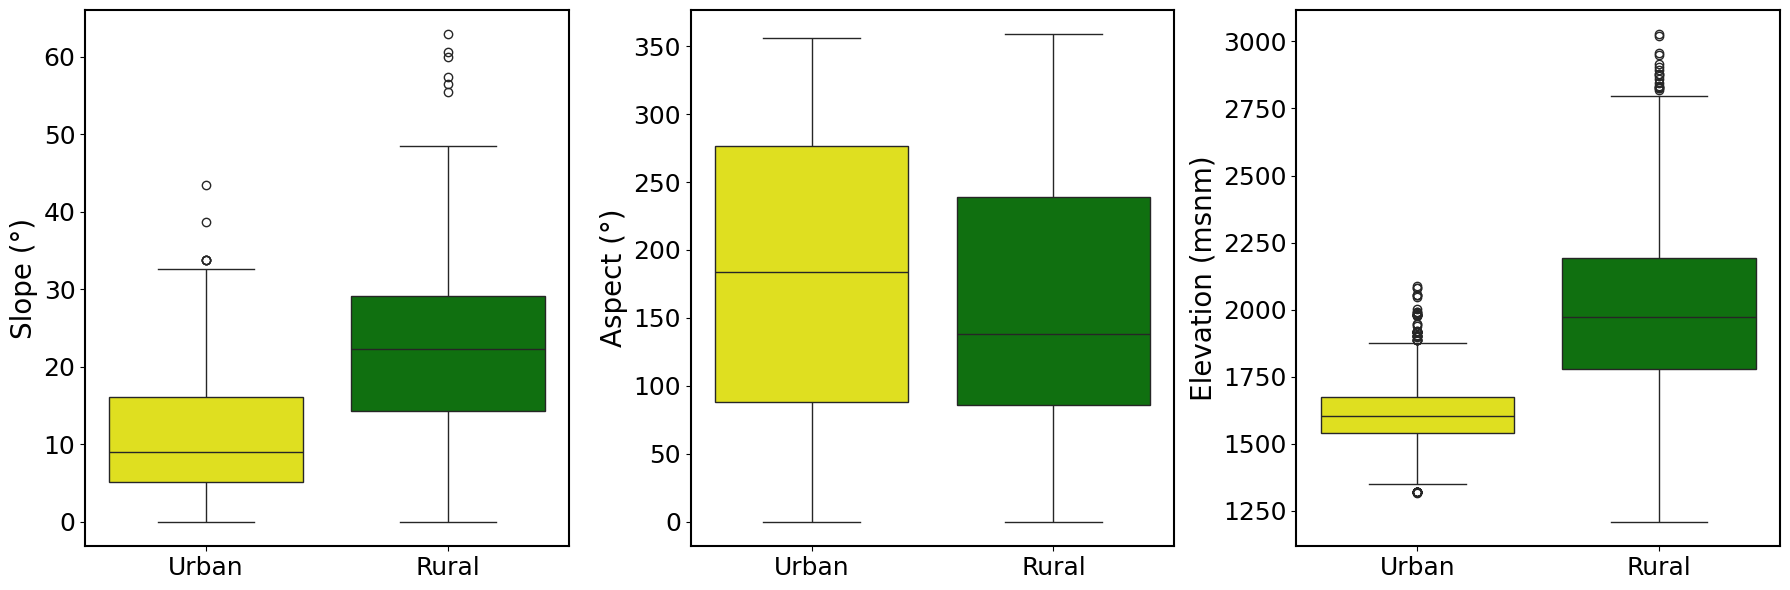

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the 'sampled' layer from the GeoPackage
gpk_file_path = '../DATA/landslides/Geohazard_RS.gpkg'  # Update with your file path
sampled_gdf = gpd.read_file(gpk_file_path, layer='sampled')

# Modify 'urban1' values: replace 1 with 'Urban' and 2 with 'Rural'
sampled_gdf['urban1'] = sampled_gdf['urban1'].replace({1: 'Urban', 2: 'Rural'})

# Selecting the variables for boxplot
columns_to_plot = ['slope1', 'aspect1', 'elevation1']

# Adjusting y-axis labels to include units: degrees for slope and aspect, and msnm for elevation
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Custom y-axis labels with units
y_labels_with_units = ['Slope (°)', 'Aspect (°)', 'Elevation (msnm)']

# Plotting each variable separately with customized labels and appearance
for i, (var, ylabel) in enumerate(zip(columns_to_plot, y_labels_with_units)):
    sns.boxplot(x='urban1', y=var, data=sampled_gdf, ax=axes[i],
                palette={'Urban': 'yellow', 'Rural': 'green'}) 
    axes[i].set_xlabel('') 
    axes[i].set_ylabel(ylabel, fontsize=20)  
    axes[i].tick_params(axis='x', labelsize=18)  
    axes[i].tick_params(axis='y', labelsize=18)

    # Explicitly set border spine thickness for top and right sides
    axes[i].spines['top'].set_visible(True)
    axes[i].spines['top'].set_linewidth(1.5)
    axes[i].spines['right'].set_visible(True)
    axes[i].spines['right'].set_linewidth(1.5)

    # Ensure bottom and left borders are present too
    axes[i].spines['bottom'].set_visible(True)
    axes[i].spines['bottom'].set_linewidth(1.5)
    axes[i].spines['left'].set_visible(True)
    axes[i].spines['left'].set_linewidth(1.5)

    # Disable the grid
    axes[i].grid(False)

# Adjust layout to avoid overlap
plt.tight_layout()

plt.savefig('../FIGURES/urban-rural.png', dpi=500, bbox_inches = "tight")
plt.show()

In [ ]:
# Ajustar etiquetas en el eje y para incluir unidades: grados para slope y aspect, y msnm para elevation
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Etiquetas personalizadas con unidades
y_labels_with_units = ['Slope (°)', 'Aspect (°)', 'Elevation (msnm)']

# Graficar cada variable con boxplot y muescas (notches)
for i, (var, ylabel) in enumerate(zip(columns_to_plot, y_labels_with_units)):
    sns.boxplot(
        x='urban1', 
        y=var, 
        data=sampled_gdf, 
        ax=axes[i],
        notch=True,  # <--- Importante para activar las muescas
        palette={'Urban': 'yellow', 'Rural': 'green'}
    )
    axes[i].set_xlabel('')
    axes[i].set_ylabel(ylabel, fontsize=20)
    axes[i].tick_params(axis='x', labelsize=18)
    axes[i].tick_params(axis='y', labelsize=18)

    # Ajustar grosor de los bordes
    axes[i].spines['top'].set_visible(True)
    axes[i].spines['top'].set_linewidth(1.5)
    axes[i].spines['right'].set_visible(True)
    axes[i].spines['right'].set_linewidth(1.5)
    axes[i].spines['bottom'].set_visible(True)
    axes[i].spines['bottom'].set_linewidth(1.5)
    axes[i].spines['left'].set_visible(True)
    axes[i].spines['left'].set_linewidth(1.5)

    axes[i].grid(False)

plt.tight_layout()
plt.savefig('../FIGURES/urban-rural.png', dpi=500, bbox_inches = "tight")

#plt.show()

## **NORMALIZACIÓN DE LOS DATOS**

In [ ]:
import rasterio
import rasterio.features
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

import rasterio
from rasterio.features import rasterize
from rasterio.enums import MergeAlg
import geopandas as gpd
import numpy as np
import pandas as pd


# 1. Leer el ráster de pendientes (slope_12)
#raster_path = '/home/oisanchezp/Geotecnia/MODELO_DE_ALERTAS/MAPA_SUSCEPTIBILIDAD/slope_12.tif'  # Ajusta a tu ruta real
# Ruta de tu ráster original en EPSG:32618

# Ruta de tu ráster original en EPSG:32618
src_raster_path = '/home/oisanchezp/Geotecnia/MODELO_DE_ALERTAS/MAPA_SUSCEPTIBILIDAD/aspect.tif'
# Nombre de salida reproyectado a WGS 84
dst_raster_path = '/home/oisanchezp/Geotecnia/MODELO_DE_ALERTAS/MAPA_SUSCEPTIBILIDAD/aspect_wgs84.tif'

# Definir CRS de origen y destino
src_crs = 'EPSG:32618'   # WGS 84 / UTM zone 18N
dst_crs = 'EPSG:4326'    # WGS 84 (lat/lon)

with rasterio.open(src_raster_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs,           # CRS de origen tomado del propio dataset
        dst_crs,           # CRS de destino
        src.width,
        src.height,
        *src.bounds
    )
    # Copiamos metadatos y los actualizamos
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Creamos/abrimos el archivo de salida
    with rasterio.open(dst_raster_path, 'w', **kwargs) as dst:
        # Reproyectamos cada banda
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest  # Puedes cambiar a bilinear o bicubic
            )

#


In [ ]:
import rasterio
from rasterio.features import rasterize
from rasterio.enums import MergeAlg
import geopandas as gpd
import numpy as np
import pandas as pd

# ------------------------------------------------------------------------------
# 1. Lectura de los tres rásteres: slope, aspect, elev
# ------------------------------------------------------------------------------
slope_path = '/home/oisanchezp/Geotecnia/MODELO_DE_ALERTAS/MAPA_SUSCEPTIBILIDAD/slope_wgs84.tif'
aspect_path = '/home/oisanchezp/Geotecnia/MODELO_DE_ALERTAS/MAPA_SUSCEPTIBILIDAD/aspect_wgs84.tif'
elev_path = '/home/oisanchezp/Geotecnia/MODELO_DE_ALERTAS/MAPA_SUSCEPTIBILIDAD/dem_wgs84.tif'

with rasterio.open(slope_path) as src_slope:
    slope_arr = src_slope.read(1)
    slope_transform = src_slope.transform
    slope_crs = src_slope.crs
    slope_nodata = src_slope.nodata

with rasterio.open(aspect_path) as src_aspect:
    aspect_arr = src_aspect.read(1)
    aspect_transform = src_aspect.transform
    aspect_crs = src_aspect.crs
    aspect_nodata = src_aspect.nodata

with rasterio.open(elev_path) as src_elev:
    elev_arr = src_elev.read(1)
    elev_transform = src_elev.transform
    elev_crs = src_elev.crs
    elev_nodata = src_elev.nodata

# Verificar que los transforms y CRS sean idénticos:
# (Si no lo son, deberás alinear y reproyectar antes.)
if not (slope_transform == aspect_transform == elev_transform):
    raise ValueError("Los rásteres no tienen la misma transform. Es necesario re-proyectar o alinear.")
if not (slope_crs == aspect_crs == elev_crs):
    raise ValueError("Los rásteres no tienen el mismo CRS. Reproyectar antes.")


# ------------------------------------------------------------------------------
# 2. Rasterizar la capa urbana/rural usando la columna 'urban' = {0,1}
# ------------------------------------------------------------------------------
urban_path = '/run/media/oisanchezp/datos/MAESTRIA/amva_urban.shp'
amva_urban_gdf = gpd.read_file(urban_path)

# Asegurar que la capa vectorial y el ráster comparten el mismo CRS
if amva_urban_gdf.crs != slope_crs:
    amva_urban_gdf = amva_urban_gdf.to_crs(slope_crs)

# Generar shapes con el valor de la columna "urban"
shapes_urban = ((row.geometry, row["urban"]) for idx, row in amva_urban_gdf.iterrows())

# Creamos un array de igual tamaño que slope_arr, para "urban"
urban_arr = rasterize(
    shapes=shapes_urban,
    out_shape=slope_arr.shape,
    transform=slope_transform,
    fill=9999,  # Valor de relleno
    merge_alg=MergeAlg.replace
)

# Donde no haya polígono, seteamos a 0 (rural).
urban_arr = np.where(urban_arr == 9999, 0, urban_arr)

# ------------------------------------------------------------------------------
# 3. Rasterizar los puntos de deslizamientos
# ------------------------------------------------------------------------------
landslide_path = '../DATA/landslides/Geohazard_RS.gpkg'
landslides_gdf = gpd.read_file(landslide_path)

# Mismo CRS
if landslides_gdf.crs != slope_crs:
    landslides_gdf = landslides_gdf.to_crs(slope_crs)

shapes_landslides = ((geom, 1) for geom in landslides_gdf.geometry)

landslide_arr = rasterize(
    shapes=shapes_landslides,
    out_shape=slope_arr.shape,
    transform=slope_transform,
    fill=0,
    merge_alg=MergeAlg.add  # Suma si caen varios puntos en el mismo píxel
)
# Convertir a binario: >=1 => 1
landslide_arr = np.where(landslide_arr > 0, 1, 0)

# ------------------------------------------------------------------------------
# 4. Crear el DataFrame
# ------------------------------------------------------------------------------
# Aplanar (flatten) cada array
slope_flat     = slope_arr.flatten()
aspect_flat    = aspect_arr.flatten()
elev_flat      = elev_arr.flatten()
urban_flat     = urban_arr.flatten()
landslide_flat = landslide_arr.flatten()

# Manejar NoData. Suponiendo que cada ráster podría tener su propio valor nodata.
# Creamos una máscara que verifique si es válido en cada uno. 
# (Si no tienes NoData, puedes saltarte esto)
mask_slope  = np.ones_like(slope_flat, dtype=bool)
mask_aspect = np.ones_like(aspect_flat, dtype=bool)
mask_elev   = np.ones_like(elev_flat, dtype=bool)

if slope_nodata is not None:
    mask_slope = slope_flat != slope_nodata
if aspect_nodata is not None:
    mask_aspect = aspect_flat != aspect_nodata
if elev_nodata is not None:
    mask_elev = elev_flat != elev_nodata

valid_mask = mask_slope & mask_aspect & mask_elev

df = pd.DataFrame({
    'slope': slope_flat[valid_mask],
    'aspect': aspect_flat[valid_mask],
    'elev': elev_flat[valid_mask],
    'urban': urban_flat[valid_mask],
    'landslide': landslide_flat[valid_mask]
})

In [ ]:
#guartar el DataFrame
df.to_csv('../DATA/landslides/urban_landslide.csv', index=False)

In [ ]:
# ------------------------------------------------------------------------------
# 1. CALCULAMOS BINS PARA SLOPE
# ------------------------------------------------------------------------------
# Bins para slope
bins_slope = [0, 10, 20, 30, 40, np.inf]  # np.inf para todo lo que exceda 40
labels_slope = ['0-10', '10-20', '20-30', '30-40', '>40']
df['slope_bin'] = pd.cut(df['slope'], bins=bins_slope, labels=labels_slope, right=False)

# ------------------------------------------------------------------------------
# 2. CALCULAMOS BINS PARA ASPECTO
# ------------------------------------------------------------------------------
def categorize_aspect(a):
    """
    Clasifica un valor de 'aspect' en una de las 8 orientaciones:
    N, NE, E, SE, S, SW, W, NW.
    Asume aspecto en rango 0 <= a < 360.
    """
    if a >= 337.5 or a < 22.5:
        return 'N'
    elif 22.5 <= a < 67.5:
        return 'NE'
    elif 67.5 <= a < 112.5:
        return 'E'
    elif 112.5 <= a < 157.5:
        return 'SE'
    elif 157.5 <= a < 202.5:
        return 'S'
    elif 202.5 <= a < 247.5:
        return 'SW'
    elif 247.5 <= a < 292.5:
        return 'W'
    elif 292.5 <= a < 337.5:
        return 'NW'
    else:
        # Por si hay valores raros fuera de rango
        return 'Undefined'
    
df['aspect_bin'] = df['aspect'].apply(categorize_aspect)

# ------------------------------------------------------------------------------
# 3. CALCULAMOS BINS PARA ALTURAS
# ------------------------------------------------------------------------------
bins_elev = [1500, 2500, np.inf]
labels_elev = ['Baja altitud', 'Altitud media', 'Alta altitud', 'Muy alta altitud']

df['elev_bin'] = pd.cut(df['elev'], bins=bins_elev, labels=labels_elev, right=False)

# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------
# 4. CALCULAR LA FRECUENCIA (RATIO) DE DESLIZAMIENTOS EN CADA BIN
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# FRECUENCIA DE DESLIZAMIENTOS POR CATEGORÍA DE SLOPE
# ------------------------------------------------------------------------------
# Contar cuántos píxeles hay en cada combinación (urban, slope_bin)
bin_counts_slope = df.groupby(['urban', 'slope_bin']).size().reset_index(name='total_pixels')

# Filtramos filas donde hay deslizamiento == 1
df_landslides = df[df['landslide'] == 1].copy()

landslide_counts_slope = df_landslides.groupby(['urban', 'slope_bin']).size().reset_index(name='landslide_count')

merged_slope = pd.merge(bin_counts_slope, landslide_counts_slope,
                        on=['urban', 'slope_bin'],
                        how='left')

# Donde no haya deslizamientos, será NaN. Reemplazamos con 0
merged_slope['landslide_count'] = merged_slope['landslide_count'].fillna(0)

# Frecuencia (porcentaje o razón)
merged_slope['frequency_ratio'] = merged_slope['landslide_count'] / merged_slope['total_pixels']


# ------------------------------------------------------------------------------
# FRECUENCIA DE DESLIZAMIENTOS POR CATEGORÍA DE ASPECT
# ------------------------------------------------------------------------------
# Aspect
bin_counts_aspect = df.groupby(['urban', 'aspect_bin']).size().reset_index(name='total_pixels')
landslide_counts_aspect = df[df['landslide'] == 1].groupby(['urban', 'aspect_bin']).size().reset_index(name='landslide_count')
merged_aspect = pd.merge(bin_counts_aspect, landslide_counts_aspect, on=['urban','aspect_bin'], how='left').fillna(0)
merged_aspect['frequency_ratio'] = merged_aspect['landslide_count'] / merged_aspect['total_pixels']

# ------------------------------------------------------------------------------
# FRECUENCIA DE DESLIZAMIENTOS POR CATEGORÍA DE ALTITUD
# ------------------------------------------------------------------------------
# Elevation
bin_counts_elev = df.groupby(['urban', 'elev_bin']).size().reset_index(name='total_pixels')
landslide_counts_elev = df[df['landslide'] == 1].groupby(['urban', 'elev_bin']).size().reset_index(name='landslide_count')
merged_elev = pd.merge(bin_counts_elev, landslide_counts_elev,
                       on=['urban', 'elev_bin'],
                       how='left')

# Rellenar con 0 SOLO la columna 'landslide_count' (que es numérica) 
merged_elev['landslide_count'] = merged_elev['landslide_count'].fillna(0)

# Si quieres un fillna en 'total_pixels' también, hazlo igual:
# merged_elev['total_pixels'] = merged_elev['total_pixels'].fillna(0)

merged_elev['frequency_ratio'] = (merged_elev['landslide_count'] / merged_elev['total_pixels'])


In [ ]:
#sumar landslide_count de urban = 1
urban_1 = merged_aspect[merged_elev['urban'] == 1].copy()
urban_1 = urban_1.groupby(['elev_bin']).agg({'landslide_count': 'sum'}).reset_index()
urban_1

In [ ]:
total_sum = merged_elev['frequency_ratio'].sum()
merged_elev['freq_ratio_norm'] = merged_elev['frequency_ratio'] / total_sum

merged_elev['sum_by_urban'] = merged_elev.groupby('urban')['frequency_ratio'].transform('sum')
merged_elev['freq_ratio_norm'] = merged_elev['frequency_ratio'] / merged_elev['sum_by_urban']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_frequency_ratio_bar(
    df, 
    category_col,      # Nombre de la columna que contiene las categorías (bins)
    freq_col='frequency_ratio', 
    urban_col='urban', 
    category_name='Slope Bins'
):
    """
    Crea un gráfico de barras agrupadas donde, para cada categoría (bin),
    se muestran dos barras: Rural (urban=0) y Urban (urban=1).

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame que contiene, al menos, las columnas:
        - 'urban' (0 o 1)
        - category_col (por ejemplo 'slope_bin')
        - freq_col (por ejemplo 'frequency_ratio')
    category_col : str
        Nombre de la columna con las categorías (bins) que irán en el eje X.
    freq_col : str
        Nombre de la columna que contiene los valores numéricos a graficar (Y).
    urban_col : str
        Nombre de la columna que indica si es Rural (0) o Urban (1).
    category_name : str
        Título o etiqueta para el eje X (se mostrará también en el título del gráfico).

    Retorna:
    --------
    None (muestra el gráfico directamente).
    """

    # Creamos una tabla pivote para separar valores de Urban=0 y Urban=1 en columnas distintas
    pivot_df = df.pivot(index=category_col, columns=urban_col, values=freq_col)

    # Aseguramos que si no hay filas para 0 o 1, las rellene con 0
    if 0 not in pivot_df.columns:
        pivot_df[0] = 0
    if 1 not in pivot_df.columns:
        pivot_df[1] = 0

    # Preparamos coordenadas X según el número de categorías
    x_labels = pivot_df.index.astype(str)
    X = np.arange(len(x_labels))
    width = 0.4  # ancho de cada barra

    # Extraemos valores para Rural (0) y Urban (1)
    rural_values = pivot_df[0].values
    urban_values = pivot_df[1].values

    # Creamos la figura y eje
    fig, ax = plt.subplots(figsize=(8, 6))

    # Dibujamos las barras
    ax.bar(X - width/2, rural_values, width=width, label='Rural')
    ax.bar(X + width/2, urban_values, width=width, label='Urban')

    # Etiquetas del eje X
    ax.set_xticks(X)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')

    # Etiquetas y título en inglés
    ax.set_ylabel('Frequency Ratio')
    ax.set_xlabel(category_name)
    ax.set_title(f'Frequency Ratio by {category_name}')
    ax.legend()

    # Ajuste para que no se corten las etiquetas
    plt.tight_layout()
    plt.show()


In [ ]:
plot_frequency_ratio_bar(
    df=merged_slope, 
    category_col='slope_bin',
    freq_col='frequency_ratio',
    urban_col='urban',
    category_name='Slope Bins (°)'
)

In [ ]:
plot_frequency_ratio_bar(
    df=merged_aspect, 
    category_col='aspect_bin',
    freq_col='frequency_ratio',
    urban_col='urban',
    category_name='Slope Bins (°)'
)

In [ ]:
plot_frequency_ratio_bar(
    df=merged_elev, 
    category_col='elev_bin',
    freq_col='frequency_ratio',
    urban_col='urban',
    category_name='Slope Bins (°)'
)